In [1]:
import pandas as pd
import numpy as np

# For reproducibility
np.random.seed(42)

# Dataset source (Pima Indians Diabetes - UCI / Brownlee)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

columns = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome"
]

# Load dataset
df = pd.read_csv(url, header=None, names=columns)

# Basic dataset inspection (important for Task 1 & Task 3)
print("Dataset Shape:", df.shape)
print("Number of Features:", df.shape[1] - 1)
print("Number of Samples:", df.shape[0])

df.head()


Dataset Shape: (768, 9)
Number of Features: 8
Number of Samples: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
import numpy as np

# Columns where zero values are medically invalid and represent missing data
zero_columns = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]

# Count zero (invalid) values in each column
zero_counts = df[zero_columns].eq(0).sum()

print("Number of invalid zero values per feature:")
zero_counts


Number of invalid zero values per feature:


,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


In [3]:
# Replace invalid zero values with the median of each feature
# Median is used instead of mean to reduce the effect of outliers

for col in zero_columns:
    median_value = df.loc[df[col] != 0, col].median()
    df.loc[df[col] == 0, col] = median_value

# Verify that no zero values remain
print("Remaining zero values after imputation:")
df[zero_columns].eq(0).sum()


Remaining zero values after imputation:


,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0


In [4]:
# Separate features and target variable
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

# Store original dataset dimensions (useful for Task 3 analysis)
num_samples, num_features = X.shape

print("Original Dataset Info:")
print("Number of samples:", num_samples)
print("Number of features:", num_features)


Original Dataset Info:
Number of samples: 768
Number of features: 8


In [5]:
from sklearn.model_selection import train_test_split

def split_dataset(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and testing sets using stratified sampling
    to preserve class distribution.
    """
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

# Split the original full dataset
X_train, X_test, y_train, y_test = split_dataset(X, y)

print("Train/Test Split (Full Dataset):")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Train/Test Split (Full Dataset):
X_train shape: (614, 8)
X_test shape: (154, 8)


In [6]:
from sklearn.preprocessing import StandardScaler

def scale_features(X_train, X_test):
    """
    Standardize features using statistics from the training set only
    to avoid data leakage.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale the full dataset
X_train, X_test = scale_features(X_train, X_test)

print("Feature scaling applied:")
print("X_train mean (approx.):", X_train.mean(axis=0)[:3])
print("X_train std (approx.):", X_train.std(axis=0)[:3])


Feature scaling applied:
X_train mean (approx.): [-1.87146715e-17 -8.02832285e-17  3.23302731e-16]
X_train std (approx.): [1. 1. 1.]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Forward pass: compute predicted probabilities
def forward(X, w, b):
    return sigmoid(np.dot(X, w) + b)

# Binary cross-entropy loss
def compute_loss(y, y_hat):
    epsilon = 1e-9  # numerical stability
    return -np.mean(
        y * np.log(y_hat + epsilon) +
        (1 - y) * np.log(1 - y_hat + epsilon)
    )

# Convert probabilities to binary class predictions
def predict(X, w, b, threshold=0.5):
    y_hat = forward(X, w, b)
    return (y_hat >= threshold).astype(int)

# Unified evaluation function (used across all algorithms)
def evaluate_model(X, y, w, b):
    y_pred = predict(X, w, b)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return acc, f1


In [8]:
import time

def gradient_descent(X, y, lr, epochs):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    losses = []

    for _ in range(epochs):
        y_hat = forward(X, w, b)

        dw = (1 / m) * np.dot(X.T, (y_hat - y))
        db = (1 / m) * np.sum(y_hat - y)

        w -= lr * dw
        b -= lr * db
        losses.append(compute_loss(y, y_hat))

    return w, b, losses


def run_gd_experiments(X_train, y_train, X_test, y_test,
                       learning_rates, epochs=2000):
    """
    Run Gradient Descent with different learning rates
    and compare performance and convergence behavior.
    """
    results = {}

    for lr in learning_rates:
        start_time = time.time()

        w, b, losses = gradient_descent(
            X_train, y_train,
            lr=lr,
            epochs=epochs
        )

        elapsed_time = time.time() - start_time
        acc, f1 = evaluate_model(X_test, y_test, w, b)

        results[lr] = {
            "weights": w,
            "bias": b,
            "losses": losses,
            "accuracy": acc,
            "f1_score": f1,
            "time": elapsed_time
        }

    return results


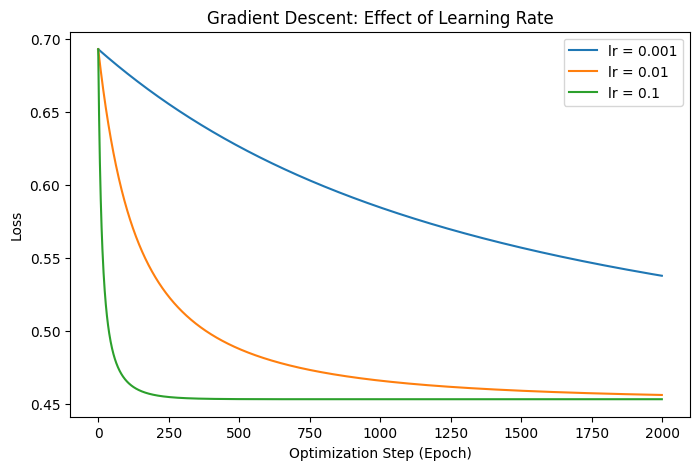


Learning Rate = 0.001
Train Accuracy: 0.7671009771986971
Test Accuracy : 0.7142857142857143
Train F1: 0.657074340527578
Test F1 : 0.6071428571428571
Training Time (sec): 0.3280501365661621

Learning Rate = 0.01
Train Accuracy: 0.7915309446254072
Test Accuracy : 0.7012987012987013
Train F1: 0.6666666666666666
Test F1 : 0.5490196078431373
Training Time (sec): 0.49311113357543945

Learning Rate = 0.1
Train Accuracy: 0.7964169381107492
Test Accuracy : 0.7077922077922078
Train F1: 0.6701846965699209
Test F1 : 0.5454545454545454
Training Time (sec): 0.4085042476654053


In [9]:
# Gradient Descent hyperparameter experiments (Task 2)

learning_rates = [0.001, 0.01, 0.1]
epochs = 2000

gd_results = {}

plt.figure(figsize=(8, 5))

for lr in learning_rates:
    start_time = time.time()

    w, b, losses = gradient_descent(
        X_train, y_train,
        lr=lr,
        epochs=epochs
    )

    elapsed_time = time.time() - start_time

    train_acc, train_f1 = evaluate_model(X_train, y_train, w, b)
    test_acc, test_f1   = evaluate_model(X_test,  y_test,  w, b)

    gd_results[lr] = {
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_f1": train_f1,
        "test_f1": test_f1,
        "time": elapsed_time,
        "losses": losses
    }

    # Plot loss curve for each learning rate
    plt.plot(losses, label=f"lr = {lr}")

plt.xlabel("Optimization Step (Epoch)")
plt.ylabel("Loss")
plt.title("Gradient Descent: Effect of Learning Rate")
plt.legend()
plt.show()

# Display numerical comparison
for lr, res in gd_results.items():
    print(f"\nLearning Rate = {lr}")
    print("Train Accuracy:", res["train_accuracy"])
    print("Test Accuracy :", res["test_accuracy"])
    print("Train F1:", res["train_f1"])
    print("Test F1 :", res["test_f1"])
    print("Training Time (sec):", res["time"])


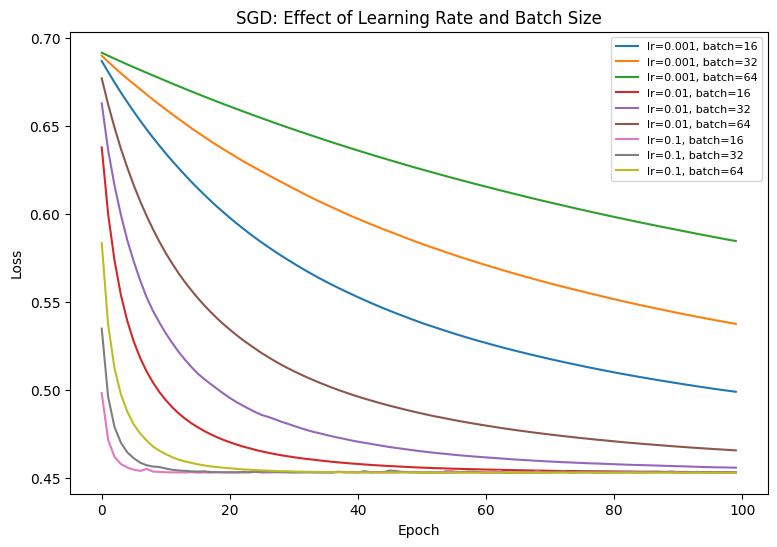


Configuration: lr=0.001, batch=16
Train Accuracy: 0.7719869706840391
Test Accuracy : 0.7142857142857143
Train F1: 0.6534653465346535
Test F1 : 0.6
Training Time (sec): 0.37645459175109863

Configuration: lr=0.001, batch=32
Train Accuracy: 0.7671009771986971
Test Accuracy : 0.7142857142857143
Train F1: 0.657074340527578
Test F1 : 0.6071428571428571
Training Time (sec): 0.4650301933288574

Configuration: lr=0.001, batch=64
Train Accuracy: 0.758957654723127
Test Accuracy : 0.7012987012987013
Train F1: 0.6509433962264151
Test F1 : 0.5964912280701754
Training Time (sec): 0.2099308967590332

Configuration: lr=0.01, batch=16
Train Accuracy: 0.7947882736156352
Test Accuracy : 0.6948051948051948
Train F1: 0.6684210526315789
Test F1 : 0.5346534653465347
Training Time (sec): 0.3794834613800049

Configuration: lr=0.01, batch=32
Train Accuracy: 0.7899022801302932
Test Accuracy : 0.7012987012987013
Train F1: 0.6649350649350649
Test F1 : 0.5490196078431373
Training Time (sec): 0.13306927680969238

C

In [10]:
import time

def sgd(X, y, lr, epochs, batch_size):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    losses = []

    for _ in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            y_hat = forward(X_batch, w, b)

            dw = (1 / len(y_batch)) * np.dot(X_batch.T, (y_hat - y_batch))
            db = (1 / len(y_batch)) * np.sum(y_hat - y_batch)

            w -= lr * dw
            b -= lr * db

        losses.append(compute_loss(y, forward(X, w, b)))

    return w, b, losses


# -------------------------
# SGD Hyperparameter Experiments (Task 2)
# -------------------------

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs = 100

sgd_results = {}

plt.figure(figsize=(9, 6))

for lr in learning_rates:
    for batch_size in batch_sizes:
        start_time = time.time()

        w, b, losses = sgd(
            X_train, y_train,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size
        )

        elapsed_time = time.time() - start_time

        train_acc, train_f1 = evaluate_model(X_train, y_train, w, b)
        test_acc, test_f1   = evaluate_model(X_test,  y_test,  w, b)

        key = f"lr={lr}, batch={batch_size}"
        sgd_results[key] = {
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1,
            "time": elapsed_time,
            "losses": losses
        }

        # Plot loss curve
        plt.plot(losses, label=key)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SGD: Effect of Learning Rate and Batch Size")
plt.legend(fontsize=8)
plt.show()

# Print numerical comparison
for key, res in sgd_results.items():
    print(f"\nConfiguration: {key}")
    print("Train Accuracy:", res["train_accuracy"])
    print("Test Accuracy :", res["test_accuracy"])
    print("Train F1:", res["train_f1"])
    print("Test F1 :", res["test_f1"])
    print("Training Time (sec):", res["time"])


In [11]:
import time

def newton_method(X, y, iterations, damping=1e-4):
    """
    Damped Newton's Method for Logistic Regression
    """
    m, n = X.shape
    Xb = np.hstack([np.ones((m, 1)), X])
    theta = np.zeros(n + 1)
    losses = []

    for _ in range(iterations):
        y_hat = sigmoid(Xb @ theta)

        gradient = (1 / m) * (Xb.T @ (y_hat - y))
        R = np.diag(y_hat * (1 - y_hat))
        hessian = (1 / m) * (Xb.T @ R @ Xb)

        # Damping for numerical stability
        hessian += damping * np.eye(n + 1)

        theta -= np.linalg.pinv(hessian) @ gradient
        losses.append(compute_loss(y, y_hat))

    return theta, losses


def evaluate_newton(X_train, y_train, X_test, y_test,
                    iterations_list, damping=1e-4):

    results = {}

    plt.figure(figsize=(8, 5))

    for iters in iterations_list:
        start_time = time.time()

        theta, losses = newton_method(
            X_train, y_train,
            iterations=iters,
            damping=damping
        )

        elapsed_time = time.time() - start_time

        y_train_pred = (sigmoid(
            np.hstack([np.ones((X_train.shape[0], 1)), X_train]) @ theta
        ) >= 0.5).astype(int)

        y_test_pred = (sigmoid(
            np.hstack([np.ones((X_test.shape[0], 1)), X_test]) @ theta
        ) >= 0.5).astype(int)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc  = accuracy_score(y_test,  y_test_pred)
        train_f1  = f1_score(y_train, y_train_pred)
        test_f1   = f1_score(y_test,  y_test_pred)

        results[iters] = {
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1,
            "time": elapsed_time,
            "losses": losses
        }

        plt.plot(losses, label=f"iterations = {iters}")

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Newton's Method: Effect of Iterations")
    plt.legend()
    plt.show()

    return results


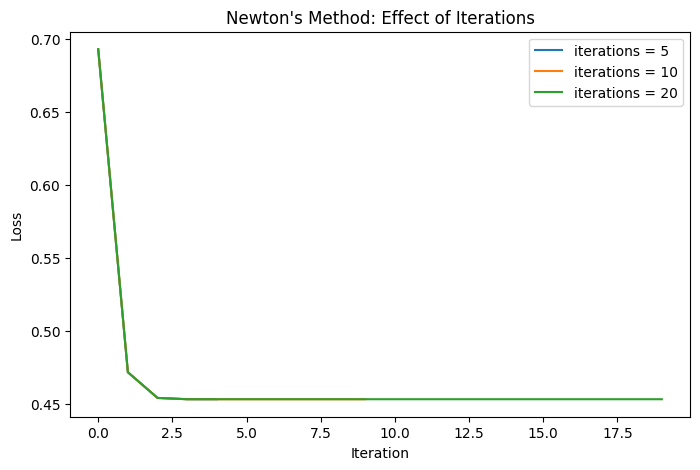

In [12]:
iterations_list = [5, 10, 20]

newton_results = evaluate_newton(
    X_train, y_train,
    X_test, y_test,
    iterations_list
)


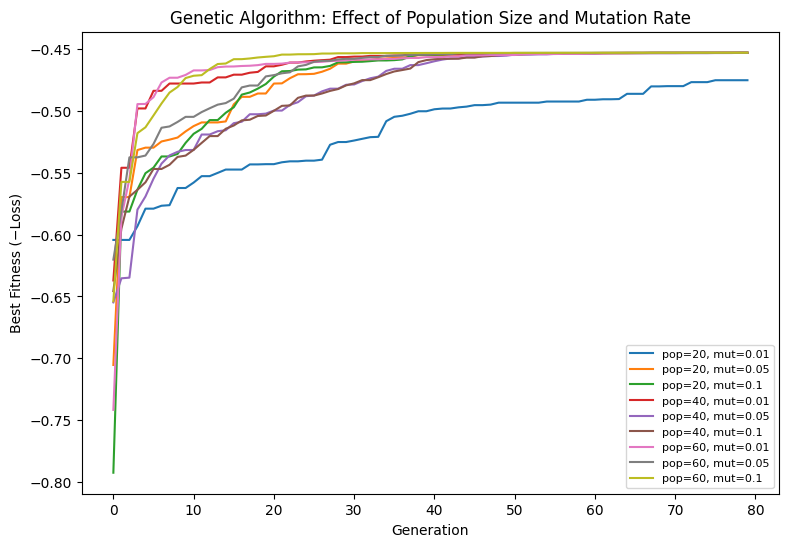


Configuration: pop=20, mut=0.01
Train Accuracy: 0.7752442996742671
Test Accuracy : 0.6948051948051948
Train F1: 0.6424870466321243
Test F1 : 0.5346534653465347
Training Time (sec): 0.3212094306945801

Configuration: pop=20, mut=0.05
Train Accuracy: 0.7964169381107492
Test Accuracy : 0.7012987012987013
Train F1: 0.6719160104986877
Test F1 : 0.54
Training Time (sec): 0.3038370609283447

Configuration: pop=20, mut=0.1
Train Accuracy: 0.7931596091205212
Test Accuracy : 0.7012987012987013
Train F1: 0.6649076517150396
Test F1 : 0.5306122448979592
Training Time (sec): 0.3204927444458008

Configuration: pop=40, mut=0.01
Train Accuracy: 0.7980456026058632
Test Accuracy : 0.6948051948051948
Train F1: 0.675392670157068
Test F1 : 0.5346534653465347
Training Time (sec): 0.88295578956604

Configuration: pop=40, mut=0.05
Train Accuracy: 0.7931596091205212
Test Accuracy : 0.6948051948051948
Train F1: 0.6649076517150396
Test F1 : 0.5252525252525253
Training Time (sec): 0.812366247177124

Configuration

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -------------------------------------------------
# GA Prediction Function
# -------------------------------------------------
def predict_ga(X, chromosome):
    w = chromosome[:-1]
    b = chromosome[-1]
    probs = sigmoid(np.dot(X, w) + b)
    return (probs >= 0.5).astype(int)


# -------------------------------------------------
# Fitness Function
# -------------------------------------------------
def fitness_function(chromosome, X, y):
    w = chromosome[:-1]
    b = chromosome[-1]
    y_hat = sigmoid(np.dot(X, w) + b)
    return -compute_loss(y, y_hat)


# -------------------------------------------------
# GA Operators
# -------------------------------------------------
def tournament_selection(population, fitnesses, k=3):
    idx = np.random.choice(len(population), k, replace=False)
    best = idx[np.argmax(fitnesses[idx])]
    return population[best].copy()


def crossover(parent1, parent2, rate=0.8):
    if np.random.rand() < rate:
        point = np.random.randint(1, len(parent1))
        c1 = np.concatenate([parent1[:point], parent2[point:]])
        c2 = np.concatenate([parent2[:point], parent1[point:]])
        return c1, c2
    return parent1.copy(), parent2.copy()


def mutation(chromosome, rate=0.05, scale=0.1):
    for i in range(len(chromosome)):
        if np.random.rand() < rate:
            chromosome[i] += np.random.normal(0, scale)
    return chromosome


# -------------------------------------------------
# Genetic Algorithm
# -------------------------------------------------
def genetic_algorithm(X, y, pop_size, generations,
                      crossover_rate, mutation_rate):
    n_features = X.shape[1]
    chrom_length = n_features + 1

    population = np.random.randn(pop_size, chrom_length)
    fitness_history = []

    for _ in range(generations):
        fitnesses = np.array([fitness_function(c, X, y) for c in population])
        fitness_history.append(np.max(fitnesses))

        new_population = []

        elite = population[np.argmax(fitnesses)].copy()
        new_population.append(elite)

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)

            c1, c2 = crossover(p1, p2, crossover_rate)
            new_population.append(mutation(c1, mutation_rate))
            new_population.append(mutation(c2, mutation_rate))

        population = np.array(new_population[:pop_size])

    final_fitnesses = np.array([fitness_function(c, X, y) for c in population])
    best_chromosome = population[np.argmax(final_fitnesses)]

    return best_chromosome, fitness_history


# -------------------------------------------------
# GA Hyperparameter Experiments (Task 2)
# -------------------------------------------------
population_sizes = [20, 40, 60]
mutation_rates = [0.01, 0.05, 0.1]
generations = 80
crossover_rate = 0.8

ga_results = {}

plt.figure(figsize=(9, 6))

for pop_size in population_sizes:
    for mut_rate in mutation_rates:
        start_time = time.time()

        best_chromosome, fitness_history = genetic_algorithm(
            X_train, y_train,
            pop_size=pop_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mut_rate
        )

        elapsed_time = time.time() - start_time

        y_train_pred = predict_ga(X_train, best_chromosome)
        y_test_pred  = predict_ga(X_test,  best_chromosome)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc  = accuracy_score(y_test,  y_test_pred)
        train_f1  = f1_score(y_train, y_train_pred)
        test_f1   = f1_score(y_test,  y_test_pred)

        key = f"pop={pop_size}, mut={mut_rate}"
        ga_results[key] = {
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1,
            "time": elapsed_time,
            "fitness_history": fitness_history
        }

        plt.plot(fitness_history, label=key)

plt.xlabel("Generation")
plt.ylabel("Best Fitness (−Loss)")
plt.title("Genetic Algorithm: Effect of Population Size and Mutation Rate")
plt.legend(fontsize=8)
plt.show()

# -------------------------------------------------
# Numerical Comparison
# -------------------------------------------------
for key, res in ga_results.items():
    print(f"\nConfiguration: {key}")
    print("Train Accuracy:", res["train_accuracy"])
    print("Test Accuracy :", res["test_accuracy"])
    print("Train F1:", res["train_f1"])
    print("Test F1 :", res["test_f1"])
    print("Training Time (sec):", res["time"])


/tmp/ipython-input-1205504361.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipython-input-1205504361.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


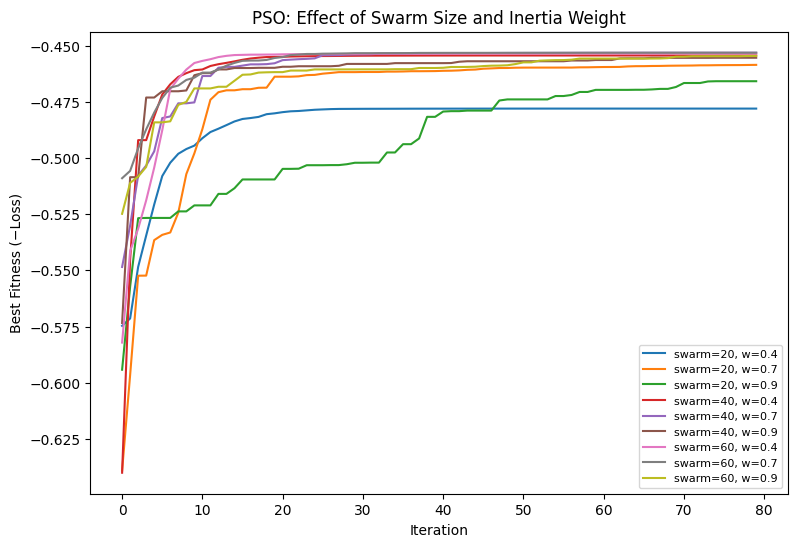


Configuration: swarm=20, w=0.4
Train Accuracy: 0.7654723127035831
Test Accuracy : 0.7012987012987013
Train F1: 0.645320197044335
Test F1 : 0.5576923076923077
Training Time (sec): 0.12148165702819824

Configuration: swarm=20, w=0.7
Train Accuracy: 0.7866449511400652
Test Accuracy : 0.7207792207792207
Train F1: 0.6733167082294265
Test F1 : 0.5825242718446602
Training Time (sec): 0.12489175796508789

Configuration: swarm=20, w=0.9
Train Accuracy: 0.7801302931596091
Test Accuracy : 0.7207792207792207
Train F1: 0.6599496221662469
Test F1 : 0.5825242718446602
Training Time (sec): 0.14724016189575195

Configuration: swarm=40, w=0.4
Train Accuracy: 0.7915309446254072
Test Accuracy : 0.6883116883116883
Train F1: 0.6649214659685864
Test F1 : 0.5294117647058824
Training Time (sec): 0.24681901931762695

Configuration: swarm=40, w=0.7
Train Accuracy: 0.7964169381107492
Test Accuracy : 0.7077922077922078
Train F1: 0.6701846965699209
Test F1 : 0.5454545454545454
Training Time (sec): 0.23662924766540

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -------------------------------------------------
# PSO Fitness & Prediction (Self-contained)
# -------------------------------------------------
def fitness_pso(position, X, y):
    w = position[:-1]
    b = position[-1]
    y_hat = sigmoid(np.dot(X, w) + b)
    return -compute_loss(y, y_hat)


def predict_pso(X, position):
    w = position[:-1]
    b = position[-1]
    return (sigmoid(np.dot(X, w) + b) >= 0.5).astype(int)


# -------------------------------------------------
# Particle Swarm Optimization
# -------------------------------------------------
def pso(X, y, swarm_size, iterations, inertia, c1, c2):
    n_features = X.shape[1]
    dim = n_features + 1

    positions = np.random.randn(swarm_size, dim)
    velocities = np.random.randn(swarm_size, dim) * 0.1

    pbest_pos = positions.copy()
    pbest_fit = np.array([fitness_pso(p, X, y) for p in positions])

    gbest_index = np.argmax(pbest_fit)
    gbest_pos = pbest_pos[gbest_index].copy()

    fitness_history = []

    for _ in range(iterations):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()

            velocities[i] = (
                inertia * velocities[i]
                + c1 * r1 * (pbest_pos[i] - positions[i])
                + c2 * r2 * (gbest_pos - positions[i])
            )

            positions[i] += velocities[i]

            fit = fitness_pso(positions[i], X, y)

            if fit > pbest_fit[i]:
                pbest_fit[i] = fit
                pbest_pos[i] = positions[i].copy()

        gbest_index = np.argmax(pbest_fit)
        gbest_pos = pbest_pos[gbest_index].copy()
        fitness_history.append(pbest_fit[gbest_index])

    return gbest_pos, fitness_history


# -------------------------------------------------
# PSO Hyperparameter Experiments (Task 2)
# -------------------------------------------------
swarm_sizes = [20, 40, 60]
inertia_weights = [0.4, 0.7, 0.9]
iterations = 80
c1 = 1.5
c2 = 1.5

pso_results = {}

plt.figure(figsize=(9, 6))

for swarm_size in swarm_sizes:
    for inertia in inertia_weights:
        start_time = time.time()

        best_position, fitness_history = pso(
            X_train, y_train,
            swarm_size=swarm_size,
            iterations=iterations,
            inertia=inertia,
            c1=c1,
            c2=c2
        )

        elapsed_time = time.time() - start_time

        y_train_pred = predict_pso(X_train, best_position)
        y_test_pred  = predict_pso(X_test,  best_position)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc  = accuracy_score(y_test,  y_test_pred)
        train_f1  = f1_score(y_train, y_train_pred)
        test_f1   = f1_score(y_test,  y_test_pred)

        key = f"swarm={swarm_size}, w={inertia}"
        pso_results[key] = {
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1,
            "time": elapsed_time,
            "fitness_history": fitness_history
        }

        plt.plot(fitness_history, label=key)

plt.xlabel("Iteration")
plt.ylabel("Best Fitness (−Loss)")
plt.title("PSO: Effect of Swarm Size and Inertia Weight")
plt.legend(fontsize=8)
plt.show()


# -------------------------------------------------
# Numerical Comparison
# -------------------------------------------------
for key, res in pso_results.items():
    print(f"\nConfiguration: {key}")
    print("Train Accuracy:", res["train_accuracy"])
    print("Test Accuracy :", res["test_accuracy"])
    print("Train F1:", res["train_f1"])
    print("Test F1 :", res["test_f1"])
    print("Training Time (sec):", res["time"])


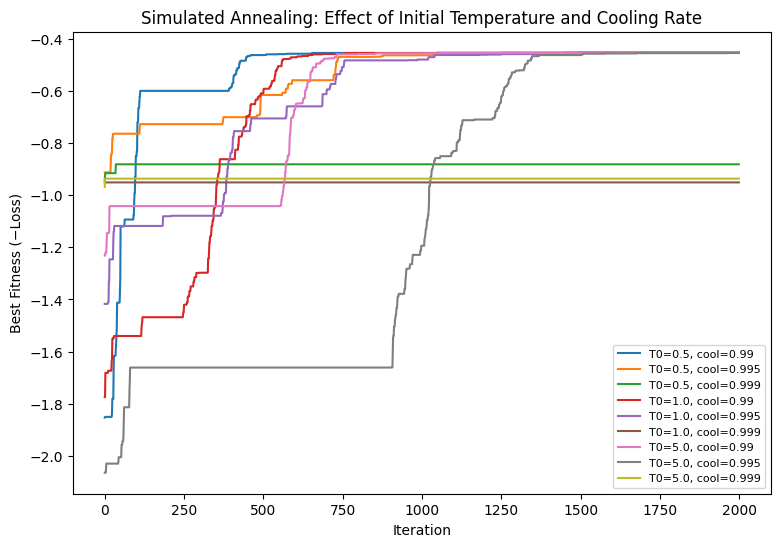


Configuration: T0=0.5, cool=0.99
Train Accuracy: 0.7915309446254072
Test Accuracy : 0.7207792207792207
Train F1: 0.6631578947368421
Test F1 : 0.5742574257425742
Training Time (sec): 0.6139094829559326

Configuration: T0=0.5, cool=0.995
Train Accuracy: 0.7850162866449512
Test Accuracy : 0.7077922077922078
Train F1: 0.6526315789473685
Test F1 : 0.5631067961165048
Training Time (sec): 1.025048017501831

Configuration: T0=0.5, cool=0.999
Train Accuracy: 0.6807817589576547
Test Accuracy : 0.6168831168831169
Train F1: 0.3950617283950617
Test F1 : 0.3058823529411765
Training Time (sec): 0.5065498352050781

Configuration: T0=1.0, cool=0.99
Train Accuracy: 0.7915309446254072
Test Accuracy : 0.7012987012987013
Train F1: 0.6666666666666666
Test F1 : 0.54
Training Time (sec): 0.5590403079986572

Configuration: T0=1.0, cool=0.995
Train Accuracy: 0.7931596091205212
Test Accuracy : 0.7012987012987013
Train F1: 0.6684073107049608
Test F1 : 0.5490196078431373
Training Time (sec): 0.32962799072265625



In [20]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -------------------------------------------------
# SA Fitness & Prediction (Self-contained)
# -------------------------------------------------
def fitness_sa(solution, X, y):
    w = solution[:-1]
    b = solution[-1]
    y_hat = sigmoid(np.dot(X, w) + b)
    return -compute_loss(y, y_hat)


def predict_sa(X, solution):
    w = solution[:-1]
    b = solution[-1]
    return (sigmoid(np.dot(X, w) + b) >= 0.5).astype(int)


# -------------------------------------------------
# Simulated Annealing
# -------------------------------------------------
def simulated_annealing(
    X, y,
    initial_temp,
    cooling_rate,
    iterations,
    step_size
):
    n_features = X.shape[1]
    dim = n_features + 1

    current = np.random.randn(dim)
    current_fitness = fitness_sa(current, X, y)

    best = current.copy()
    best_fitness = current_fitness

    T = initial_temp
    fitness_history = []

    for _ in range(iterations):
        neighbor = current + np.random.normal(0, step_size, size=dim)
        neighbor_fitness = fitness_sa(neighbor, X, y)

        delta = neighbor_fitness - current_fitness

        if delta > 0 or np.random.rand() < np.exp(delta / T):
            current = neighbor
            current_fitness = neighbor_fitness

            if current_fitness > best_fitness:
                best = current.copy()
                best_fitness = current_fitness

        fitness_history.append(best_fitness)
        T *= cooling_rate

    return best, fitness_history


# -------------------------------------------------
# SA Hyperparameter Experiments (Task 2)
# -------------------------------------------------
initial_temps = [0.5, 1.0, 5.0]
cooling_rates = [0.99, 0.995, 0.999]
iterations = 2000
step_size = 0.1

sa_results = {}

plt.figure(figsize=(9, 6))

for temp in initial_temps:
    for cool in cooling_rates:
        start_time = time.time()

        best_solution, fitness_history = simulated_annealing(
            X_train, y_train,
            initial_temp=temp,
            cooling_rate=cool,
            iterations=iterations,
            step_size=step_size
        )

        elapsed_time = time.time() - start_time

        y_train_pred = predict_sa(X_train, best_solution)
        y_test_pred  = predict_sa(X_test,  best_solution)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc  = accuracy_score(y_test,  y_test_pred)
        train_f1  = f1_score(y_train, y_train_pred)
        test_f1   = f1_score(y_test,  y_test_pred)

        key = f"T0={temp}, cool={cool}"
        sa_results[key] = {
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_f1": train_f1,
            "test_f1": test_f1,
            "time": elapsed_time,
            "fitness_history": fitness_history
        }

        plt.plot(fitness_history, label=key)

plt.xlabel("Iteration")
plt.ylabel("Best Fitness (−Loss)")
plt.title("Simulated Annealing: Effect of Initial Temperature and Cooling Rate")
plt.legend(fontsize=8)
plt.show()


# -------------------------------------------------
# Numerical Comparison
# -------------------------------------------------
for key, res in sa_results.items():
    print(f"\nConfiguration: {key}")
    print("Train Accuracy:", res["train_accuracy"])
    print("Test Accuracy :", res["test_accuracy"])
    print("Train F1:", res["train_f1"])
    print("Test F1 :", res["test_f1"])
    print("Training Time (sec):", res["time"])


In [21]:
import pandas as pd

def extract_best_result(results_dict):
    """
    Extract the best configuration based on test accuracy.
    """
    best_key = max(results_dict, key=lambda k: results_dict[k]["test_accuracy"])
    best = results_dict[best_key]
    return best["test_accuracy"], best["test_f1"], best["time"]


# Extract best results for each algorithm
gd_acc, gd_f1, gd_time = extract_best_result(gd_results)
sgd_acc, sgd_f1, sgd_time = extract_best_result(sgd_results)
newton_acc, newton_f1, newton_time = extract_best_result(newton_results)
ga_acc, ga_f1, ga_time = extract_best_result(ga_results)
pso_acc, pso_f1, pso_time = extract_best_result(pso_results)
sa_acc, sa_f1, sa_time = extract_best_result(sa_results)

# Create summary table
results = pd.DataFrame({
    "Algorithm": ["GD", "SGD", "Newton", "GA", "PSO", "SA"],
    "Best_Test_Accuracy": [
        gd_acc,
        sgd_acc,
        newton_acc,
        ga_acc,
        pso_acc,
        sa_acc
    ],
    "Best_Test_F1": [
        gd_f1,
        sgd_f1,
        newton_f1,
        ga_f1,
        pso_f1,
        sa_f1
    ],
    "Training_Time_sec": [
        gd_time,
        sgd_time,
        newton_time,
        ga_time,
        pso_time,
        sa_time
    ]
})

results


,Algorithm,Best_Test_Accuracy,Best_Test_F1,Training_Time_sec
0,GD,0.714286,0.607143,0.328050
1,SGD,0.714286,0.600000,0.376455
2,Newton,0.707792,0.545455,0.067412
3,GA,0.707792,0.545455,1.374815
4,PSO,0.720779,0.582524,0.124892
5,SA,0.720779,0.574257,0.613909


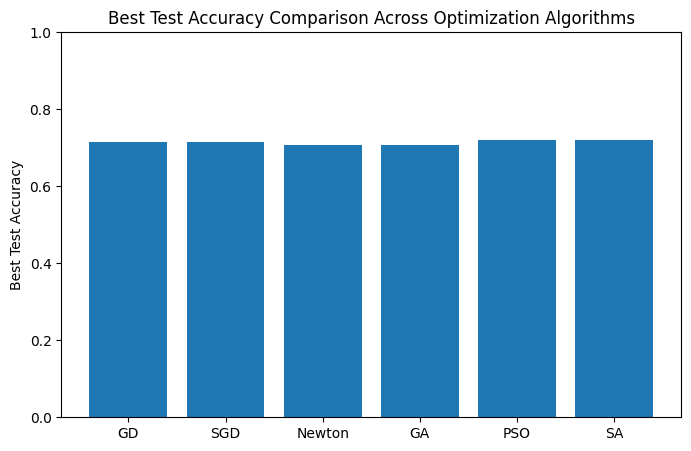

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results["Algorithm"], results["Best_Test_Accuracy"])
plt.ylabel("Best Test Accuracy")
plt.title("Best Test Accuracy Comparison Across Optimization Algorithms")
plt.ylim(0, 1)
plt.show()


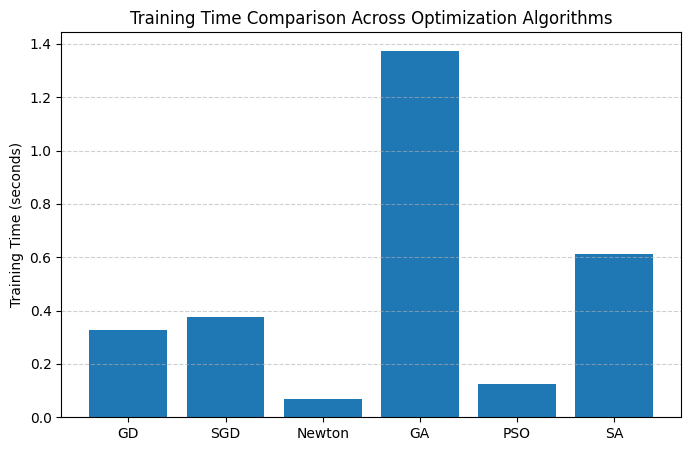

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(results["Algorithm"], results["Training_Time_sec"])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison Across Optimization Algorithms")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [24]:
import numpy as np

def reduce_rows(X, y, ratio, random_state=42):
    """
    Reduce dataset size by randomly sampling a given ratio of rows.
    """
    np.random.seed(random_state)
    size = int(len(X) * ratio)
    indices = np.random.choice(len(X), size=size, replace=False)
    return X[indices], y[indices]


In [26]:
ratios = [1.0, 0.5, 0.25]


In [28]:
# Prediction function for Newton's Method
def predict_newton(X, theta):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    probs = sigmoid(Xb @ theta)
    return (probs >= 0.5).astype(int)


In [29]:
import time

gd_acc_rows, gd_time_rows = [], []
sgd_acc_rows, sgd_time_rows = [], []
newton_acc_rows, newton_time_rows = [], []
ga_acc_rows, ga_time_rows = [], []
pso_acc_rows, pso_time_rows = [], []
sa_acc_rows, sa_time_rows = [], []

for r in ratios:
    # 1) Reduce rows from FULL dataset
    X_r, y_r = reduce_rows(X, y, r)

    # 2) Train/Test split
    Xr_train, Xr_test, yr_train, yr_test = split_dataset(X_r, y_r)

    # 3) Scaling
    Xr_train, Xr_test = scale_features(Xr_train, Xr_test)

    # ---------------- GD ----------------
    start = time.time()
    w, b, _ = gradient_descent(Xr_train, yr_train, lr=0.01, epochs=1000)
    gd_time_rows.append(time.time() - start)

    y_pred = predict(Xr_test, w, b)
    gd_acc_rows.append(accuracy_score(yr_test, y_pred))

    # ---------------- SGD ----------------
    start = time.time()
    w, b, _ = sgd(Xr_train, yr_train, lr=0.01, epochs=100, batch_size=32)
    sgd_time_rows.append(time.time() - start)

    y_pred = predict(Xr_test, w, b)
    sgd_acc_rows.append(accuracy_score(yr_test, y_pred))

    # ---------------- Newton ----------------
    start = time.time()
    theta, _ = newton_method(Xr_train, yr_train, iterations=20)
    newton_time_rows.append(time.time() - start)

    y_pred = predict_newton(Xr_test, theta)
    newton_acc_rows.append(accuracy_score(yr_test, y_pred))

    # ---------------- GA ----------------
    start = time.time()
    best_chrom, _ = genetic_algorithm(
        Xr_train, yr_train,
        pop_size=40, generations=80,
        crossover_rate=0.8, mutation_rate=0.05
    )
    ga_time_rows.append(time.time() - start)

    y_pred = predict_ga(Xr_test, best_chrom)
    ga_acc_rows.append(accuracy_score(yr_test, y_pred))

    # ---------------- PSO ----------------
    start = time.time()
    best_pos, _ = pso(
        Xr_train, yr_train,
        swarm_size=40, iterations=80,
        inertia=0.7, c1=1.5, c2=1.5
    )
    pso_time_rows.append(time.time() - start)

    y_pred = predict_pso(Xr_test, best_pos)
    pso_acc_rows.append(accuracy_score(yr_test, y_pred))

    # ---------------- SA ----------------
    start = time.time()
    best_sol, _ = simulated_annealing(
        Xr_train, yr_train,
        initial_temp=1.0,
        cooling_rate=0.995,
        iterations=2000,
        step_size=0.1
    )
    sa_time_rows.append(time.time() - start)

    y_pred = predict_sa(Xr_test, best_sol)
    sa_acc_rows.append(accuracy_score(yr_test, y_pred))


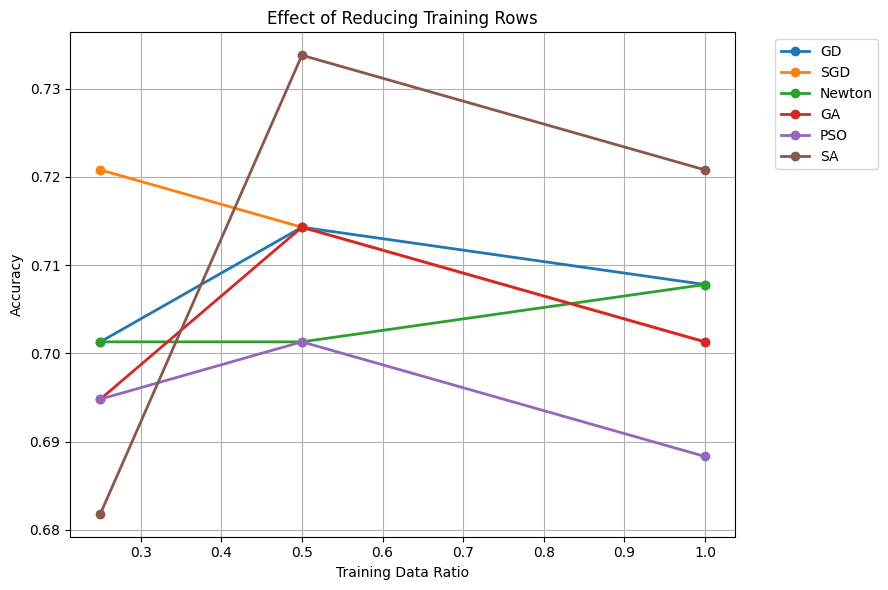

In [47]:
ratios_sorted = [0.25, 0.5, 1.0]

plt.figure(figsize=(9,6))

plt.plot(ratios_sorted, gd_acc_rows[::-1], marker='o', linewidth=2, label="GD")
plt.plot(ratios_sorted, sgd_acc_rows[::-1], marker='o', linewidth=2, label="SGD")
plt.plot(ratios_sorted, newton_acc_rows[::-1], marker='o', linewidth=2, label="Newton")
plt.plot(ratios_sorted, ga_acc_rows[::-1], marker='o', linewidth=2, label="GA")
plt.plot(ratios_sorted, pso_acc_rows[::-1], marker='o', linewidth=2, label="PSO")
plt.plot(ratios_sorted, sa_acc_rows[::-1], marker='o', linewidth=2, label="SA")

plt.xlabel("Training Data Ratio")
plt.ylabel("Accuracy")
plt.title("Effect of Reducing Training Rows")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
feature_sets = [8, 4, 2]

gd_acc_features = []
sgd_acc_features = []
newton_acc_features = []
ga_acc_features = []
pso_acc_features = []
sa_acc_features = []


In [31]:
# ===== Task 3 Global Definitions =====

# Ratios for row reduction
ratios = [1.0, 0.5, 0.25]

# Feature sets
feature_sets = [8, 4, 2]

print("Task 3 variables initialized:")
print("ratios =", ratios)
print("feature_sets =", feature_sets)


Task 3 variables initialized:
ratios = [1.0, 0.5, 0.25]
feature_sets = [8, 4, 2]


In [32]:
import time
from sklearn.metrics import accuracy_score

gd_acc_features, gd_time_features = [], []
sgd_acc_features, sgd_time_features = [], []
newton_acc_features, newton_time_features = [], []
ga_acc_features, ga_time_features = [], []
pso_acc_features, pso_time_features = [], []
sa_acc_features, sa_time_features = [], []

for f in feature_sets:
    # 1) Reduce features from FULL dataset
    X_f = X[:, :f]
    y_f = y.copy()

    # 2) Train/Test split
    Xf_train, Xf_test, yf_train, yf_test = split_dataset(X_f, y_f)

    # 3) Scaling
    Xf_train, Xf_test = scale_features(Xf_train, Xf_test)

    # ---------------- GD ----------------
    start = time.time()
    w, b, _ = gradient_descent(Xf_train, yf_train, lr=0.01, epochs=1000)
    gd_time_features.append(time.time() - start)
    gd_acc_features.append(
        accuracy_score(yf_test, predict(Xf_test, w, b))
    )

    # ---------------- SGD ----------------
    start = time.time()
    w, b, _ = sgd(Xf_train, yf_train, lr=0.01, epochs=100, batch_size=32)
    sgd_time_features.append(time.time() - start)
    sgd_acc_features.append(
        accuracy_score(yf_test, predict(Xf_test, w, b))
    )

    # ---------------- Newton ----------------
    start = time.time()
    theta, _ = newton_method(Xf_train, yf_train, iterations=20)
    newton_time_features.append(time.time() - start)
    newton_acc_features.append(
        accuracy_score(yf_test, predict_newton(Xf_test, theta))
    )

    # ---------------- GA ----------------
    start = time.time()
    best_chrom, _ = genetic_algorithm(
        Xf_train, yf_train,
        pop_size=40, generations=80,
        crossover_rate=0.8, mutation_rate=0.05
    )
    ga_time_features.append(time.time() - start)
    ga_acc_features.append(
        accuracy_score(yf_test, predict_ga(Xf_test, best_chrom))
    )

    # ---------------- PSO ----------------
    start = time.time()
    best_pos, _ = pso(
        Xf_train, yf_train,
        swarm_size=40, iterations=80,
        inertia=0.7, c1=1.5, c2=1.5
    )
    pso_time_features.append(time.time() - start)
    pso_acc_features.append(
        accuracy_score(yf_test, predict_pso(Xf_test, best_pos))
    )

    # ---------------- SA ----------------
    start = time.time()
    best_sol, _ = simulated_annealing(
        Xf_train, yf_train,
        initial_temp=1.0,
        cooling_rate=0.995,
        iterations=2000,
        step_size=0.1
    )
    sa_time_features.append(time.time() - start)
    sa_acc_features.append(
        accuracy_score(yf_test, predict_sa(Xf_test, best_sol))
    )


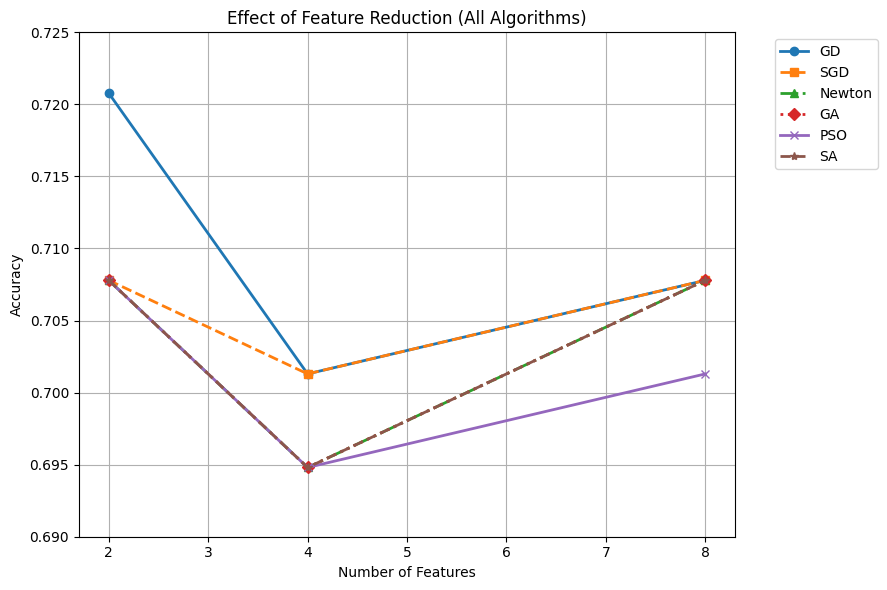

In [49]:
features_sorted = [2, 4, 8]

plt.figure(figsize=(9,6))

plt.plot(features_sorted, gd_acc_features[::-1], marker='o', linestyle='-', linewidth=2, label="GD")
plt.plot(features_sorted, sgd_acc_features[::-1], marker='s', linestyle='--', linewidth=2, label="SGD")
plt.plot(features_sorted, newton_acc_features[::-1], marker='^', linestyle='-.', linewidth=2, label="Newton")
plt.plot(features_sorted, ga_acc_features[::-1], marker='D', linestyle=':', linewidth=2, label="GA")
plt.plot(features_sorted, pso_acc_features[::-1], marker='x', linestyle='-', linewidth=2, label="PSO")
plt.plot(features_sorted, sa_acc_features[::-1], marker='*', linestyle='--', linewidth=2, label="SA")

plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Effect of Feature Reduction (All Algorithms)")

plt.ylim(0.69, 0.725)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

# ---- ensure correct feature order ----
features_sorted = [2, 4, 8]

# ---- build results table (ordered to match plots) ----
feat_results = pd.DataFrame({
    "Features": features_sorted,
    "GD": gd_acc_features[::-1],
    "SGD": sgd_acc_features[::-1],
    "Newton": newton_acc_features[::-1],
    "GA": ga_acc_features[::-1],
    "PSO": pso_acc_features[::-1],
    "SA": sa_acc_features[::-1]
})

feat_results


,Features,GD,SGD,Newton,GA,PSO,SA
0,2,0.720779,0.707792,0.707792,0.707792,0.707792,0.707792
1,4,0.701299,0.701299,0.694805,0.694805,0.694805,0.701299
2,8,0.707792,0.701299,0.707792,0.701299,0.707792,0.707792


Selected Feature Indices: [1 2 4 5]
Number of Selected Features: 4


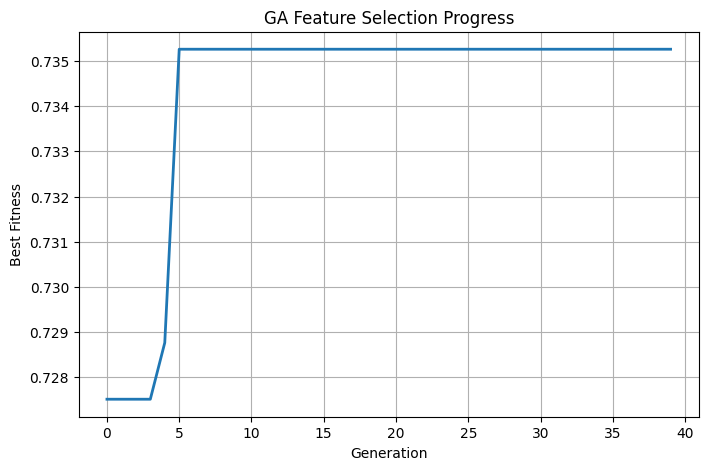

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# =========================
# Configuration
# =========================
NUM_FEATURES = X_train.shape[1]
POP_SIZE = 30
GENERATIONS = 40
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.05
ALPHA = 0.01   # penalty factor

# =========================
# Fitness Function
# =========================
def fitness_feature_selection(chromosome, X_train, y_train, X_test, y_test):
    # if no feature selected
    if np.sum(chromosome) == 0:
        return 0

    Xtr = X_train[:, chromosome == 1]
    Xte = X_test[:, chromosome == 1]

    w, b, _ = gradient_descent(Xtr, y_train, lr=0.01, epochs=800)
    y_pred = predict(Xte, w, b)

    acc = accuracy_score(y_test, y_pred)
    penalty = ALPHA * (np.sum(chromosome) / NUM_FEATURES)

    return acc - penalty


# =========================
# GA Operators
# =========================
def init_population(pop_size, n_features):
    return np.random.randint(0, 2, size=(pop_size, n_features))

def tournament_selection(pop, fitness, k=3):
    idx = np.random.choice(len(pop), k, replace=False)
    return pop[idx[np.argmax(fitness[idx])]].copy()

def crossover(p1, p2, rate=0.8):
    if np.random.rand() < rate:
        point = np.random.randint(1, len(p1))
        return (
            np.concatenate([p1[:point], p2[point:]]),
            np.concatenate([p2[:point], p1[point:]])
        )
    return p1.copy(), p2.copy()

def mutation(chrom, rate=0.05):
    for i in range(len(chrom)):
        if np.random.rand() < rate:
            chrom[i] = 1 - chrom[i]
    return chrom


# =========================
# Genetic Algorithm
# =========================
population = init_population(POP_SIZE, NUM_FEATURES)
fitness_history = []

for _ in range(GENERATIONS):
    fitness = np.array([
        fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
        for ind in population
    ])

    fitness_history.append(np.max(fitness))

    new_population = []
    elite = population[np.argmax(fitness)].copy()
    new_population.append(elite)

    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitness)
        p2 = tournament_selection(population, fitness)
        c1, c2 = crossover(p1, p2, CROSSOVER_RATE)
        new_population.append(mutation(c1, MUTATION_RATE))
        new_population.append(mutation(c2, MUTATION_RATE))

    population = np.array(new_population[:POP_SIZE])


# =========================
# Best Solution
# =========================
best_chromosome = population[np.argmax([
    fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
    for ind in population
])]

selected_features = np.where(best_chromosome == 1)[0]

print("Selected Feature Indices:", selected_features)
print("Number of Selected Features:", len(selected_features))

# =========================
# Plot Fitness
# =========================
plt.figure(figsize=(8,5))
plt.plot(fitness_history, linewidth=2)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Feature Selection Progress")
plt.grid(True)
plt.show()


In [51]:
def ga_feature_selection(
    X_train, y_train, X_test, y_test,
    pop_size=20,
    generations=30,
    crossover_rate=0.8,
    mutation_rate=0.05
):
    population = init_population(pop_size, NUM_FEATURES)
    best_fitness_history = []

    for _ in range(generations):
        fitness = np.array([
            fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
            for ind in population
        ])

        best_fitness_history.append(np.max(fitness))

        new_population = []
        elite = population[np.argmax(fitness)].copy()
        new_population.append(elite)

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitness)
            p2 = tournament_selection(population, fitness)

            c1, c2 = crossover(p1, p2, crossover_rate)
            c1 = mutation(c1, mutation_rate)
            c2 = mutation(c2, mutation_rate)

            new_population.extend([c1, c2])

        population = np.array(new_population[:pop_size])

    final_fitness = np.array([
        fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
        for ind in population
    ])

    best_solution = population[np.argmax(final_fitness)]
    return best_solution, best_fitness_history


In [52]:
best_features, fitness_history = ga_feature_selection(
    X_train, y_train, X_test, y_test,
    pop_size=20,
    generations=30
)

best_features


array([0, 1, 0, 0, 0, 0, 1, 1])

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score

# ===============================
# GA Feature Selection (SELF-CONTAINED)
# ===============================

NUM_FEATURES = X_train.shape[1]

def fitness_feature_selection(chromosome, X_train, y_train, X_test, y_test, alpha=0.01):
    if np.sum(chromosome) == 0:
        return 0

    Xtr = X_train[:, chromosome == 1]
    Xte = X_test[:, chromosome == 1]

    w, b, _ = gradient_descent(Xtr, y_train, lr=0.01, epochs=400)
    y_pred = predict(Xte, w, b)

    acc = accuracy_score(y_test, y_pred)
    penalty = alpha * (np.sum(chromosome) / NUM_FEATURES)

    return acc - penalty


def init_population(pop_size, n_features):
    return np.random.randint(0, 2, size=(pop_size, n_features))


def tournament_selection(pop, fitness, k=3):
    idx = np.random.choice(len(pop), k, replace=False)
    return pop[idx[np.argmax(fitness[idx])]].copy()


def crossover(p1, p2, rate=0.8):
    if np.random.rand() < rate:
        point = np.random.randint(1, len(p1))
        return (
            np.concatenate([p1[:point], p2[point:]]),
            np.concatenate([p2[:point], p1[point:]])
        )
    return p1.copy(), p2.copy()


def mutation(chrom, rate=0.05):
    for i in range(len(chrom)):
        if np.random.rand() < rate:
            chrom[i] = 1 - chrom[i]
    return chrom


def ga_feature_selection(X_train, y_train, X_test, y_test,
                         pop_size=20, generations=30,
                         crossover_rate=0.8, mutation_rate=0.05):

    population = init_population(pop_size, NUM_FEATURES)

    for _ in range(generations):
        fitness = np.array([
            fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
            for ind in population
        ])

        new_population = []
        elite = population[np.argmax(fitness)].copy()
        new_population.append(elite)

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitness)
            p2 = tournament_selection(population, fitness)
            c1, c2 = crossover(p1, p2, crossover_rate)
            new_population.append(mutation(c1, mutation_rate))
            new_population.append(mutation(c2, mutation_rate))

        population = np.array(new_population[:pop_size])

    final_fitness = np.array([
        fitness_feature_selection(ind, X_train, y_train, X_test, y_test)
        for ind in population
    ])

    best_solution = population[np.argmax(final_fitness)]
    return best_solution


# ===============================
# RUN + COMPARE
# ===============================

best_features = ga_feature_selection(
    X_train, y_train, X_test, y_test,
    pop_size=20,
    generations=30
)

# All features
w_all, b_all, _ = gradient_descent(X_train, y_train, lr=0.01, epochs=1000)
acc_all = accuracy_score(y_test, predict(X_test, w_all, b_all))

# Selected features
Xtr_sel = X_train[:, best_features == 1]
Xte_sel = X_test[:, best_features == 1]

w_sel, b_sel, _ = gradient_descent(Xtr_sel, y_train, lr=0.01, epochs=1000)
acc_sel = accuracy_score(y_test, predict(Xte_sel, w_sel, b_sel))

print("Selected feature indices:", np.where(best_features == 1)[0])
print("Number of selected features:", np.sum(best_features))
print("Accuracy (All Features):", acc_all)
print("Accuracy (Selected Features):", acc_sel)


Selected feature indices: [1 6 7]
Number of selected features: 3
Accuracy (All Features): 0.7077922077922078
Accuracy (Selected Features): 0.7337662337662337


In [54]:
fs_results = pd.DataFrame({
    "Model": ["All Features", "GA Selected Features"],
    "Num_Features": [
        X_train.shape[1],
        np.sum(best_features)
    ],
    "Accuracy": [
        acc_all,
        acc_sel
    ]
})

fs_results


,Model,Num_Features,Accuracy
0,All Features,8,0.707792
1,GA Selected Features,3,0.733766


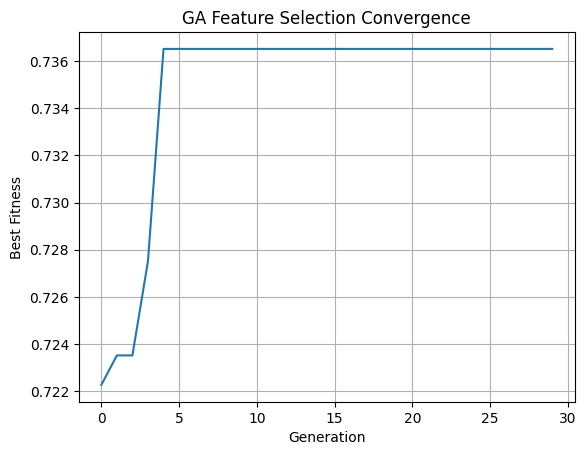

In [55]:
plt.figure()
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Feature Selection Convergence")
plt.grid(True)
plt.show()
